# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* **Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.**
* **Apply a distortion correction to raw images.**
* **Use color transforms, gradients, etc., to create a thresholded binary image.**
* **Apply a perspective transform to rectify binary image ("birds-eye view").**
* **Detect lane pixels and fit to find the lane boundary.**
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
___________________

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
from moviepy.editor import VideoFileClip

%matplotlib inline

## Goal 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

### Plot one image and evaluate it's characteristics

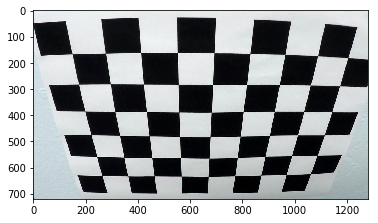

In [2]:
name = 'camera_cal/calibration2.jpg'
img = cv2.imread(name)
plt.imshow(img)

Here I can see nx = 9 and ny = 6

In [3]:
nx = 9
ny = 6

Taking inspiration from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb for camera callibration.

Detecting corners in chessboards

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
#         cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(100)


Using the corners detected from chessboards and using that to calliberate camera

I am showcasing a case that failed while corner detection and also saving the calibration result at **camera_cal/wide_dist_pickle.p**

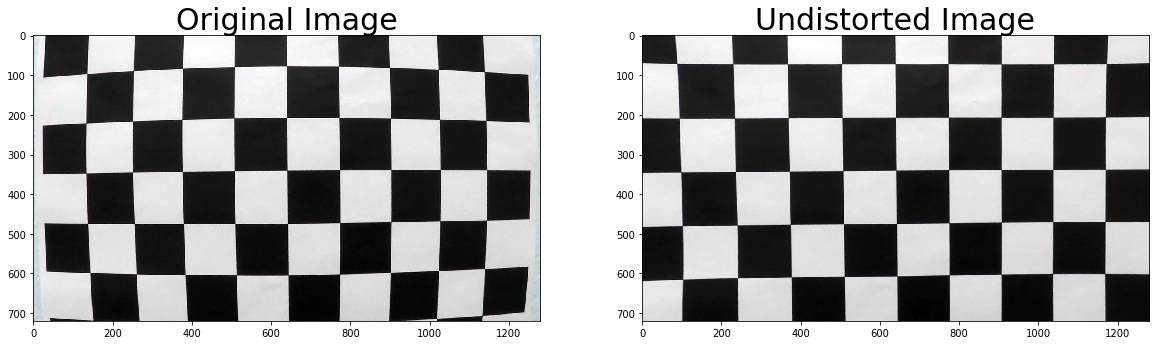

In [5]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('camera_cal/calibration1_undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Goal 2: Apply a distortion correction to raw images.


In [6]:
# Given an image, it undistorts an image from memory loaded mtx and dist
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

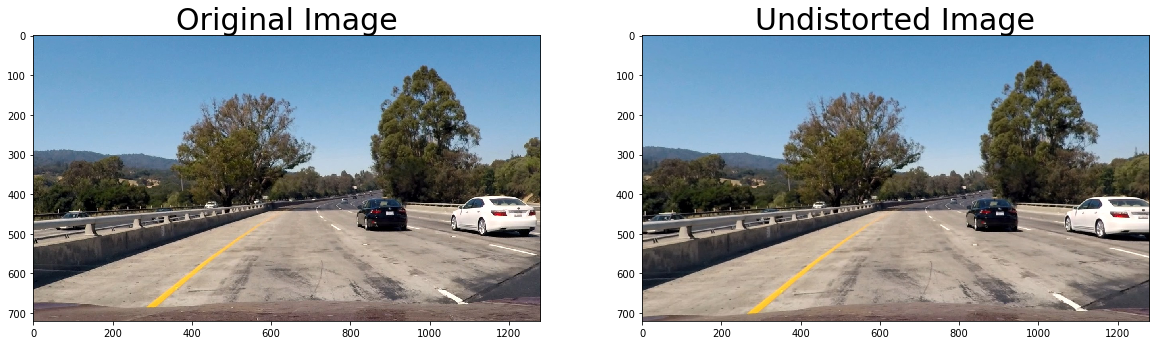

In [7]:
img = cv2.imread('test_images/test1.jpg')
dst = undistort(img)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Now storing undistored images to **output_images** folder

In [8]:
images = glob.glob('test_images/*')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img)
    cv2.imwrite('output_images/undistorted/' + fname.split('/')[1], dst)

## Goal 3: Use color transforms, gradients, etc., to create a thresholded binary image.

### Magnitute Thresholding

In [72]:
# Generate binary output with magnitute threshold.
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return binary_output

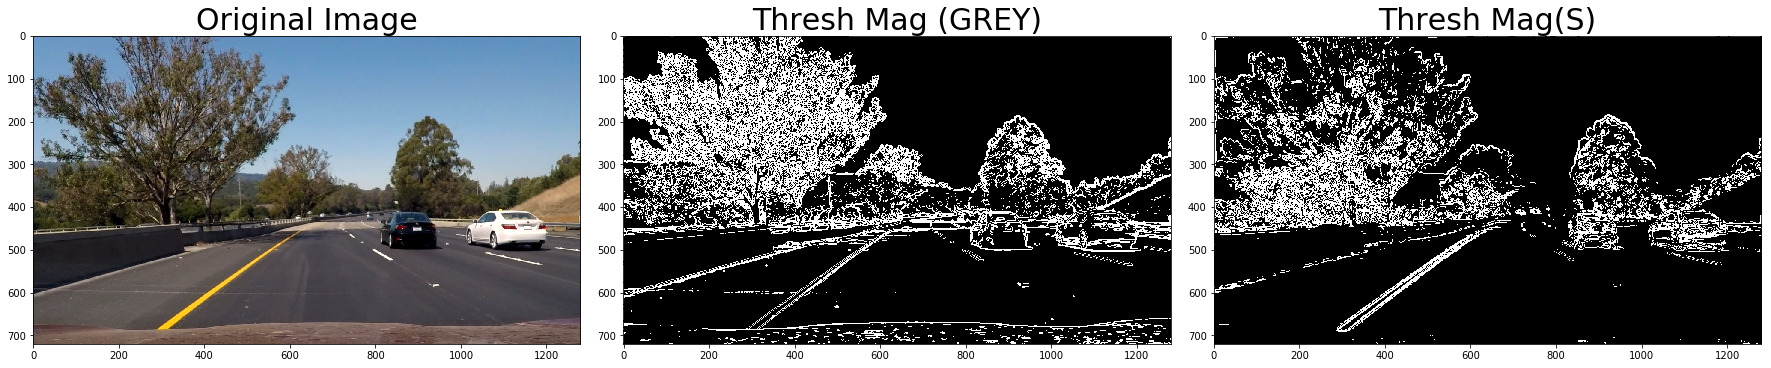

In [74]:
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
    

mag_gray_binary = mag_thresh(gray, sobel_kernel=5, mag_thresh=(20, 100))
mag_s_binary = mag_thresh(s_channel, sobel_kernel=5, mag_thresh=(20, 100))
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_gray_binary, cmap='gray')
ax2.set_title('Thresh Mag (GREY)', fontsize=30)
ax3.imshow(mag_s_binary, cmap='gray')
ax3.set_title('Thresh Mag(S)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Direction of gradient

In [75]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

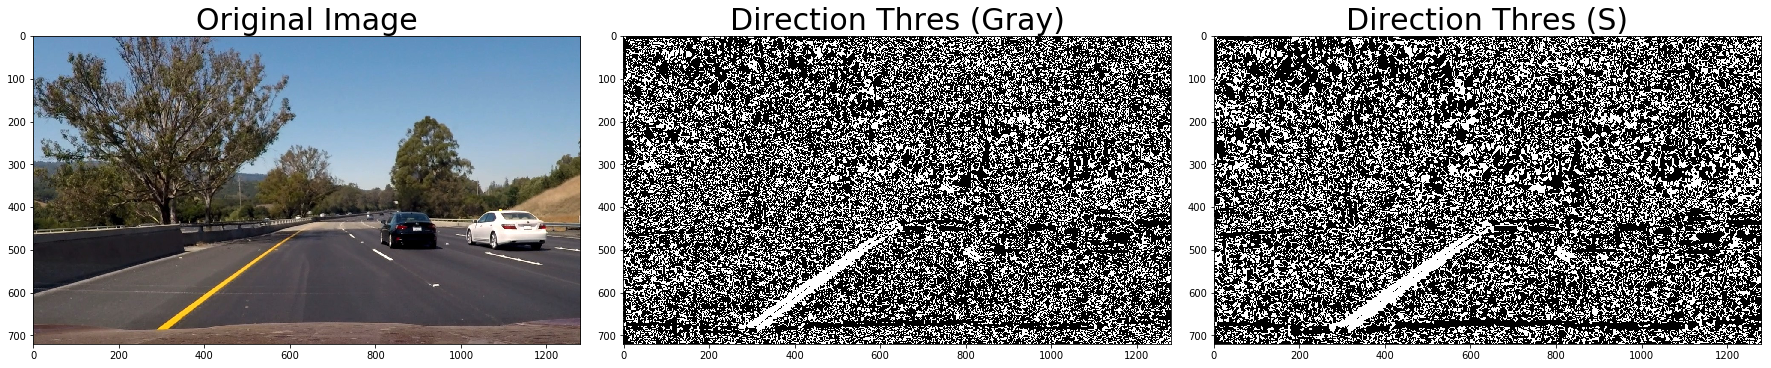

In [87]:

img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

dir_binary =dir_threshold(s_channel, sobel_kernel=17, thresh=(0.7, 1.3))
dir_s_binary = dir_threshold(s_channel, sobel_kernel=31, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Direction Thres (Gray)', fontsize=30)
ax3.imshow(dir_s_binary, cmap='gray')
ax3.set_title('Direction Thres (S)', fontsize = 30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Absolute Sobel Threshold

In [92]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

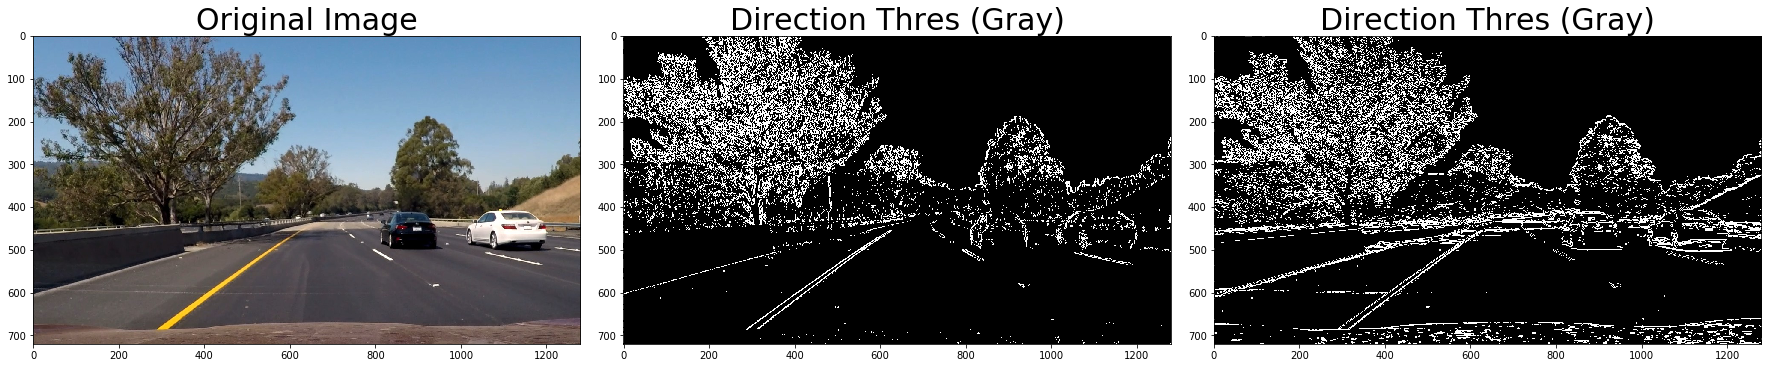

In [94]:

img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

dir_x_binary =abs_sobel_thresh(img, orient='x',thresh_min=20, thresh_max=100)
dir_y_binary = abs_sobel_thresh(img, orient='y',thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_x_binary, cmap='gray')
ax2.set_title('Direction Thres (Gray)', fontsize=30)
ax3.imshow(dir_y_binary, cmap='gray')
ax3.set_title('Direction Thres (Gray)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining the thresholds

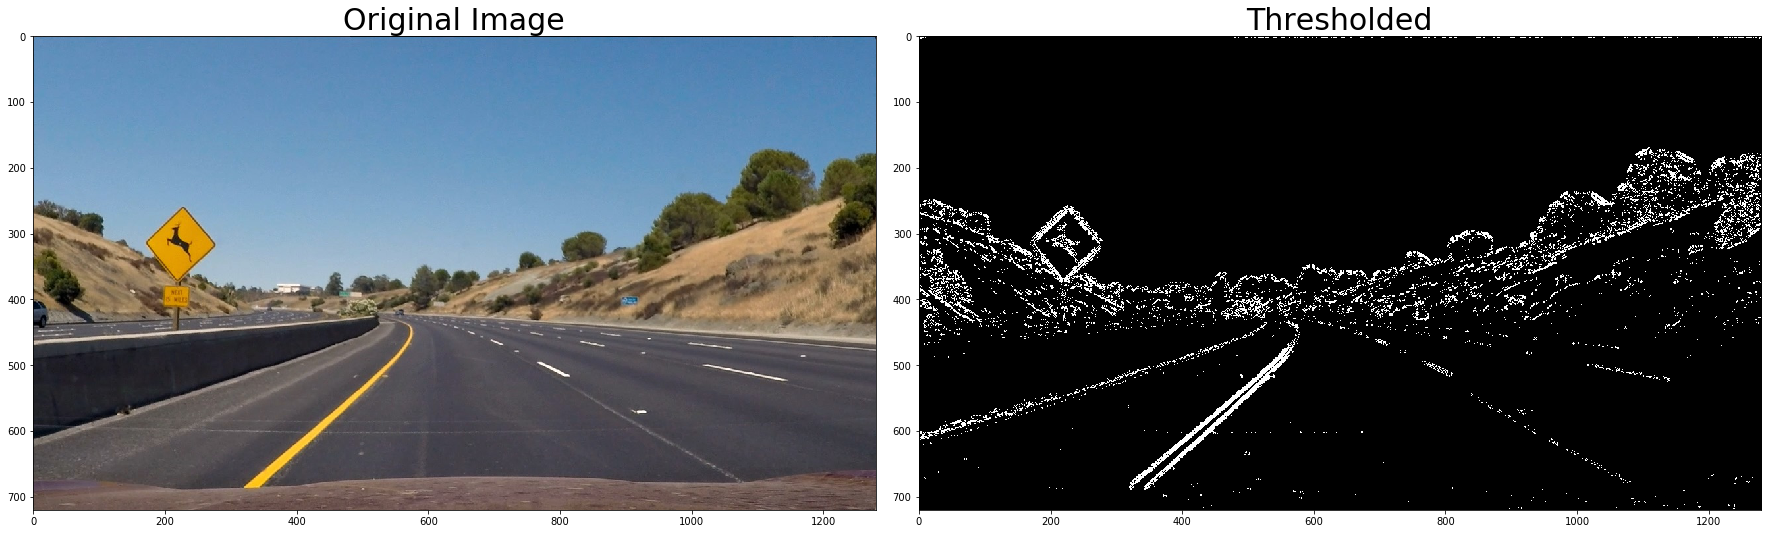

In [102]:
def combined_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)

    dir_s_binary = dir_threshold(s_channel, sobel_kernel=15, thresh=(0.7, 1.3))
    mag_s_binary = mag_thresh(s_channel, sobel_kernel=3, mag_thresh=(20, 100))
    
    combined = np.zeros_like(dir_s_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_s_binary == 1) & (dir_s_binary == 1))] = 1
    
    return combined

img = cv2.imread('test_images/test2.jpg')
combined = combined_threshold(img)
combined_without_abs = combined_threshold_without_abs(img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now storing undistored images to **output_images/thresholded** folder

In [103]:
images = glob.glob('test_images/*')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = combined_threshold(img)
    cv2.imwrite('output_images/thresholded/' + fname.split('/')[1], np.dstack((dst, dst, dst))*255)

## Goal 4: Apply a perspective transform to rectify binary image ("birds-eye view").

In [104]:
def draw_quadrilateral(image, points, color=[255, 255, 0], width=1):
    p1, p2, p3, p4 = points
    cv2.line(image, tuple(p1), tuple(p2), color, width)
    cv2.line(image, tuple(p2), tuple(p3), color, width)
    cv2.line(image, tuple(p3), tuple(p4), color, width)
    cv2.line(image, tuple(p4), tuple(p1), color, width)

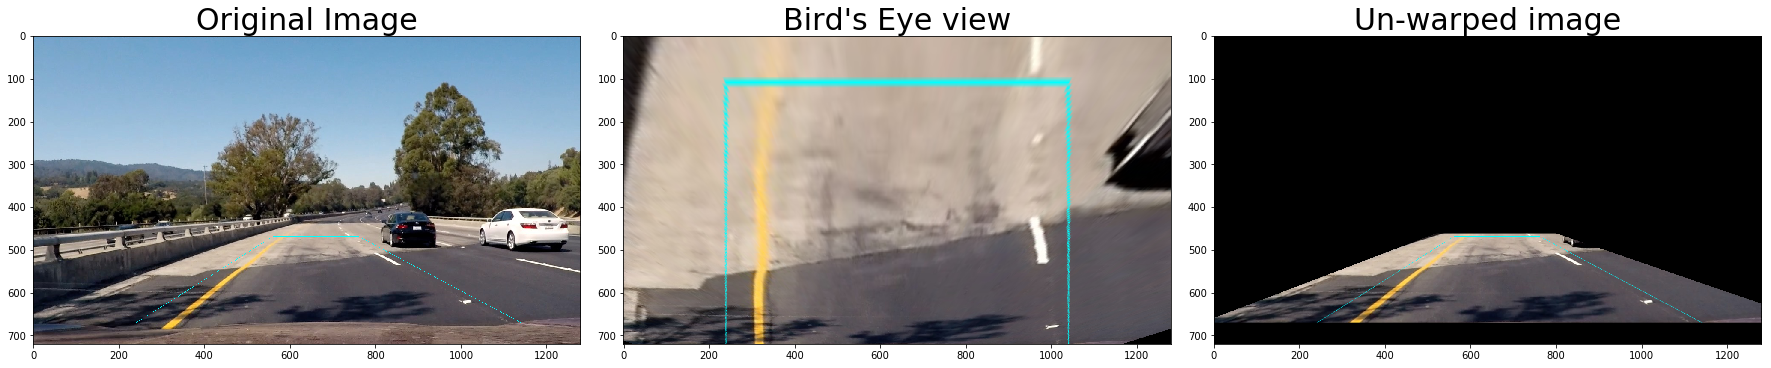

In [122]:
img = cv2.imread('test_images/test4.jpg')

height, width = img.shape[0:2]
size_top = 80
size_bottom=400
src_points = np.float32(
    [
        [(width/2) - size_top, height*0.65],        
        [(width/2) + size_top+40, height*0.65],        
        [(width/2) + size_bottom + 100, height-50],
        [(width/2) - size_bottom, height-50]
    ])

dst_points = np.float32(
    [
        [(width/2) - size_bottom, height*0.15],        
        [(width/2) + size_bottom, height*0.15],        
        [(width/2) + size_bottom, height],
        [(width/2) - size_bottom, height]
    ])

M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

draw_quadrilateral(img, src_points)

warped_image = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
unwarped_image = cv2.warpPerspective(warped_image, Minv, (width, height), flags=cv2.INTER_LINEAR)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(warped_image,cv2.COLOR_BGR2RGB))
ax2.set_title("Bird's Eye view", fontsize=30)
ax3.imshow(cv2.cvtColor(unwarped_image,cv2.COLOR_BGR2RGB))
ax3.set_title("Un-warped image", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Goal 5: Detect lane pixels and fit to find the lane boundary.

We will first take a curved road from bird's eye view

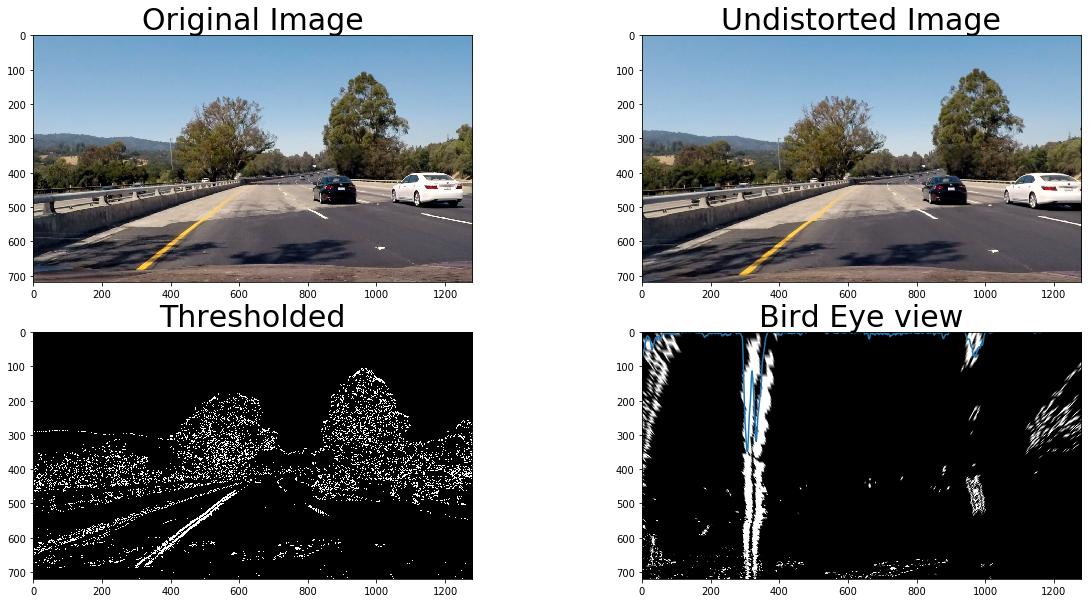

In [123]:
img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Un distorted image
dst = undistort(img)

#Threasholded image
combined = combined_threshold(img)

warped_image = cv2.warpPerspective(combined, M, (width, height), flags=cv2.INTER_LINEAR)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Thresholded', fontsize=30)
ax4.imshow(warped_image, cmap='gray')
ax4.set_title('Bird Eye view', fontsize=30)

histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [124]:
images = glob.glob('test_images/*')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = combined_threshold(img)
    warped_image = cv2.warpPerspective(dst, M, (width, height), flags=cv2.INTER_LINEAR)
    cv2.imwrite('output_images/warped/' + fname.split('/')[1], np.dstack((warped_image, warped_image, warped_image))*255)

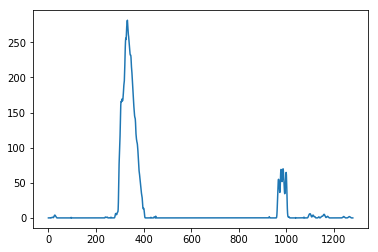

In [125]:
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

Finding lane lines in image, Using the code mentioned in study material.

In [126]:
# Given a binary warped image return the fit polynomials value 
def fit_polynomials(binary_warped, plot=False):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 100

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plot:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='red')
        plt.plot(right_fitx, ploty, color='blue')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return ploty, left_fitx, right_fitx, left_fit, right_fit


In [127]:
def fast_fit_polynomials(binary_warped, left_fit,  right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit

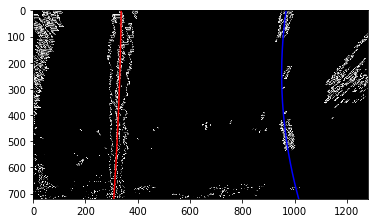

In [128]:
# Given fit ploynomials value, draw the image

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Un distorted image
dst = undistort(img)

#Threasholded image
combined = combined_threshold(img)

warped_image = cv2.warpPerspective(combined, M, (width, height), flags=cv2.INTER_LINEAR)

#Prepare binary image for showcase
out_img = np.dstack((warped_image, warped_image, warped_image))*255

# Fetch the lane points from above explained methods
ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomials(warped_image,plot=True)


## Goal 6: Determine the curvature of the lane and vehicle position with respect to center.

In [129]:
def get_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')

    return (left_curverad+right_curverad)/2


In [130]:
def render_lane(image, ploty, left_fitx, right_fitx):

    Minv = cv2.getPerspectiveTransform(dst_points, src_points)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result


In [138]:

global_left_fit = None
global_right_fit = None

def process_image(input_image):
    global global_left_fit
    global global_right_fit
    
    # step 1: undistort image
    image_undistort = undistort(input_image)
    
    # step 3: detect binary lane markings
    image_binary = combined_threshold(image_undistort)
    
    
    # step 2: perspective transform
    image_transformed = cv2.warpPerspective(image_binary, M, (width, height), flags=cv2.INTER_LINEAR)
    
    
    # step 4: fit polynomials
    if global_left_fit is not None:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fast_fit_polynomials(image_transformed, global_left_fit, global_right_fit)
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomials(image_transformed)
    
    global_left_fit = left_fit
    global_right_fit = right_fit
    
    # step 5: draw lane
    output_lane = render_lane(image_undistort, ploty, left_fitx, right_fitx)
    
    # step 6: print curvature
    curv = get_curvature(ploty, left_fitx, right_fitx)
    output_curvature = cv2.putText(output_lane, "Curvature: " + str(int(curv)) + "m", (900, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # step 7: print road position
    xm_per_pix = 3.7/700
    left_lane_pos = left_fitx[len(left_fitx)-1]
    right_lane_pos = right_fitx[len(right_fitx)-1]
    road_pos = (((left_lane_pos + right_lane_pos) / 2) - 640) * xm_per_pix
    output_road_pos = cv2.putText(output_curvature, "Offset: {0:.2f}m".format(road_pos), (900, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # output from processing step
    output_image = output_road_pos
        
    # function should always output color images
    if len(output_image.shape) == 2:
        return cv2.cvtColor(np.float32(output_image), cv2.COLOR_GRAY2RGB)
    else:
        return output_image


In [139]:
images = glob.glob('test_images/*')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = process_image(img)
    warped_image = cv2.warpPerspective(dst, M, (width, height), flags=cv2.INTER_LINEAR)
    cv2.imwrite('output_images/detection/' + fname.split('/')[1], dst)

# img = cv2.imread('test_images/test3.jpg')
# dst = process_image(img)

In [140]:
project_output_file = "project_output_3.mp4"
project_video = VideoFileClip("project_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)


[MoviePy] >>>> Building video project_output_3.mp4
[MoviePy] Writing video project_output_3.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  5.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_3.mp4 

CPU times: user 4min 31s, sys: 51.5 s, total: 5min 23s
Wall time: 4min 5s
